# Bandits and exploration/exploitation

DISCLAIMER: This is a notebook built upon the first assignment of the coursera specialization on Reinforcement Learning. Due to the fact that the course requires RL-glue, which seems to no longer be supported, I had to adapt the code in order to use the more standardized OpenAI Gym module.

### Contents of this notebook

This notebook has the intention of analysing the basis of the Reinforcement Learning problem, through the use of the k-Armed Bandits problem. With this in mind, strategies that uncover the exploration/explotation dilemma come to the spot. Here, several techniques will be analyzed to counter the dilemma, and their effectiveness, as well as shortfalls will be showcased through experimentation

## Section 0: Preliminaries

Let's first import the required libraries for this demonstration. We're going to be using the popular OpenAI's `gym` library as our RL framework.

In [22]:
# Import necessary libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm import tqdm
import time

## Section 1: The environment

Now, we need to implement our specific problem using the `gym` interface. The k-Armed Bandits Testbed environment isn't implemented inside gym, but we can create our own environment. This is for educational purposes, and is taken from [this implementation](https://github.com/diegoalejogm/openai-k-armed-bandits).

In [23]:
from gym import spaces
from gym.utils import seeding

class ArmedBanditsEnv(gym.Env):
    """
    The famous k-Armed Bandit Environment, implemented for the gym interface.
    Initialization requires an array of length equals to k, where each item is
    a function which samples from a specified distribution.
    """
    metadata = {'render.modes': ['human']}
    
    def __init__(self, mean, stddev):
        assert len(mean.shape) == 2
        assert len(stddev.shape) == 2
        
        super(ArmedBanditsEnv, self).__init__()
        # Define action and observation space
        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]
        self.action_space = spaces.Discrete(self.num_bandits)
        
        # Theres one state only in the k-armed bandits problem
        self.observation_space = spaces.Discrete(1)
        self.mean = mean
        self.stddev = stddev
        
    def step(self, action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()
        
        sampled_means = self.mean[np.arange(self.num_experiments),action]
        sampled_stddevs = self.stddev[np.arange(self.num_experiments),action]
        
        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs, size=(self.num_experiments,))
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsGaussian(ArmedBanditsEnv):
    def __init__(self, num_experiments=1, num_bandits=3):
        self.means = np.random.normal(size=(num_experiments, num_bandits))
        
        ArmedBanditsEnv.__init__(self, self.means, np.ones((num_experiments, num_bandits)))

In [24]:
# Thest the environment
test_env = ArmedBanditsGaussian(5, 10)
# test_env.action_space
obs, reward, done, info = test_env.step(np.ones((5,)).astype(np.uint8))
assert obs is 0
assert reward.shape == (5,)

Looking closely at the code, we can see that every time we take an action, we're sampling from a given distribution at the desired bandit. This is a pretty simple environment, so there's not much going on. Another class is provided to simplify the process of creating a k-armed bandit with normal distributions.

## Section 2: The Greedy Agent

We want to create an agent that will find the action with the highest expected reward. ONe way an agent could operate is to always choose the action with the highest value based on the agent's current estimates. This is called a greedy agent as it greedily chooses the action that it thinks has the highest value. Let's look at what happens in this case.

First we are going to implement the argmax function, which takes in a list of action values and returns an action with the highest value. Why are we implementing our own instead of using the argmax function that numpy uses? Numpy's argmax function returns the first instance of the highest value. We do not want that to happen as it biases the agent ot choose a specific action in the case of ties. Instead we want to break ties between the highest values randomly. So we are going to implement our own argmac function. You may want to look at [np.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html) to randomly select from a list of values.

In [25]:
def argmax(q_values):
    """
    Takes in a matrix of n*k q_values and returns the index
    of the item with the highest value for each row. 
    Breaks ties randomly.
    returns: vector of size n, where each item is the index of
    the highest value in q_values for each row.
    """
    # Generate noise to be added to the ties
    r_noise = 1e-6*np.random.random(q_values.shape)
    return np.argmax(q_values + r_noise,axis=1)


In [26]:
# Test the argmax implementation
test_array = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]])
assert argmax(test_array) == 8, "Check your argmax implementation returns the index of the largest value"

# Test on matrix
test_matrix = np.array([[0,0,1],[1,0,0],[0,1,0],[0,0,1]])
np.testing.assert_array_equal(argmax(test_matrix),np.array([2,0,1,2]), err_msg="Check your argmax implementation returns the index of the largest value for each row of a matrix")

# Test ties are broken randomly
tied_matrix = np.array([[0]*10]*100)
tied_return = argmax(tied_matrix)
# assert that results for 100 ties are random (not the same)
assert np.any(tied_return) and not np.all(tied_return), "Check your argmax implementation breaks ties randomly"


Now we're going to build our `GreedyAgent`. Our agent needs to be able to take an action, and have an estimate of the expected rewards each action yields. Our agent will always choose the greedy action, which means it will always select the action that has the highest expected reward.

In order for the agent to be able to update the estimates incrementally, we need to store both the current estimates, as well as the number of times each action has been chosen

In [27]:
class GreedyAgent:
    def __init__(self, reward_estimates):
        """
        Our agent takes as input the initial reward estimates.
        This estimates will be updated incrementally after each 
        interaction with the environment.
        """
        assert len(reward_estimates.shape) == 2
        
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.reward_estimates = reward_estimates.astype(np.float64)
        self.action_count = np.zeros(reward_estimates.shape)
        
    def get_action(self):
        # Our agent is greedy, so there's no need for exploration.
        # Our argmax will do just fine for this situation
        action = argmax(self.reward_estimates)
        
        # Add a 1 to each action selected in the action count
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action
    
    def update_estimates(self, reward, action):
        # rew is a matrix with the obtained rewards from our previuos
        # action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        
        # Compute the difference between the received rewards vs the reward estimates
        error = reward - self.reward_estimates[np.arange(self.num_experiments), action]
        
        # Update the reward difference incementally
        self.reward_estimates[np.arange(self.num_experiments), action] += (1/n)*error

In [28]:
# Test the GreedyAgent
test_agent = GreedyAgent(np.zeros((5,10)))

assert test_agent.num_bandits == 10
assert test_agent.num_experiments == 5

# Take an action
action = test_agent.get_action()
assert (action < test_agent.num_bandits).all(), "Some action fall outside the action space"
assert (test_agent.action_count[np.arange(5), action] == 1).all(), "There was an error counting the taken actions"

# Update the estimates
test_agent.update_estimates(np.ones((5,)), action)
assert (np.sum(test_agent.reward_estimates, axis=1) == 1).all(), "The estimates have not been updated correctly"

# Check that action counting adds up correctly
test_agent = GreedyAgent(np.zeros((5,10))) # Reinitialize the agent for clarity
iterations = 1000
for i in range(iterations):
    test_agent.get_action()
    
assert (np.sum(test_agent.action_count, axis=1) == iterations).all(), "Some actions were counted wrongly"


Let's now put our agent to the test. We're going to run 1000 steps with 2000 experiments running concurrently. Our environment will contain 10 possible actions.

100%|██████████| 1000/1000 [00:05<00:00, 197.63it/s]


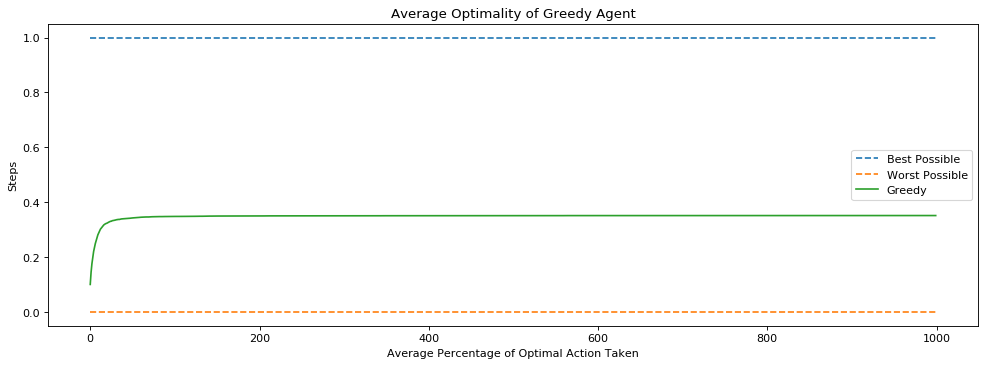

In [29]:
num_experiments = 10000
num_steps = 1000
num_actions = 10

# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)
    
    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score
    
    # Get optimal actions from the environment
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality
    
plt.figure(figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent")
plt.xlabel("Average Percentage of Optimal Action Taken")
plt.ylabel("Steps")
plt.show()
greedy_scores = averages
greedy_optimality = optimality

## Section 3: Epsilon-Greedy Agent

As seen previously, a greedy agent is far from being optimal. This is due to de fact that the agent doesn't take the chance to explore its environment a little more before heading with what seems to be a good choice. If instead of always choosing the best estimate, the agent takes an exploratory action every once in a while, it will be easier for it to find an optimal action.

This type of agent is called an epsilon-greedy agent, where epsilon denotes the probability of our agent taking an exploratory action in every step.

In [30]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, epsilon):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        self.epsilon = epsilon
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for everyone
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action

Since most of the functionality was already done in the GreedyAgent class, here we only override the functions that need to be redefined

In [31]:
# Test the agent
test_agent = EpsilonGreedyAgent(np.array([[1,0,0],[0,0,1]]), 0) # Greedy agent

test_results = np.array([[0.,0.,0.],[0.,0.,0.]])
test_iterations = 10000

# For the test we're going to do some sort of Monte-Carlo Simulation
# We want to see that the probabilities for each action are as expected
for _ in range(test_iterations):
    action = test_agent.get_action()
    test_results[np.arange(len(action)),action] += 1/test_iterations
    
print("Should yield an array close to [1.,0.,0.]")
print(test_results)

print("=========================================")
# Completely exploratory agent. Epsilon 1

test_agent = EpsilonGreedyAgent(np.array([[1,0,0],[0,0,1]]), 1) # Random agent

test_results = np.array([[0.,0.,0.],[0.,0.,0.]])

for _ in range(test_iterations):
    action = test_agent.get_action()
    test_results[np.arange(len(action)),action] += 1/test_iterations

print("Should yield an array close to [0.33,0.33,0.33]")
print(test_results)

print("=========================================")
# exploratory agent. Epsilon 1

test_agent = EpsilonGreedyAgent(np.array([[1,0,0],[0,0,1]]), 0.5) # fifty-fifty agent

test_results = np.array([[0.,0.,0.],[0.,0.,0.]])

for _ in range(test_iterations):
    action = test_agent.get_action()
    test_results[np.arange(len(action)),action] += 1/test_iterations

print("Should yield an array close to [0.667,0.1667,0.1667]")
print(test_results)




Should yield an array close to [1.,0.,0.]
[[1. 0. 0.]
 [0. 0. 1.]]
Should yield an array close to [0.33,0.33,0.33]
[[0.3308 0.3291 0.3401]
 [0.3333 0.3343 0.3324]]
Should yield an array close to [0.667,0.1667,0.1667]
[[0.6645 0.1625 0.173 ]
 [0.1767 0.1687 0.6546]]


Now that we have our epsilon greedy agent created. Let's compare it against the greedy agent with epsilon of 0.1.

In [32]:
def run_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:05<00:00, 182.57it/s]


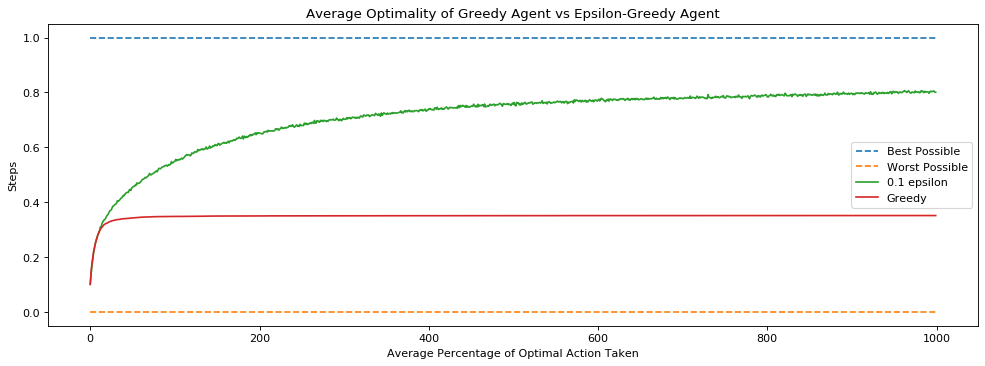

In [33]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilon = 0.1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(balanced_eps_optimality)
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.1 epsilon", "Greedy"])
plt.title("Average Optimality of Greedy Agent vs Epsilon-Greedy Agent")
plt.xlabel("Average Percentage of Optimal Action Taken")
plt.ylabel("Steps")
plt.show()

Notice how much better the epsilon-greedy agent did. Because we occasionally choose a random action we were able to find a better long term policy. By acting greedily before our value estimates are accurate, we risk settling on a suboptimal action.

## Section 4: Comparin values of epsilon

Can we do better than an epsilon of 0.1? Let's try several different values for epsilon and see how they perform. We try different settings of key performance parameters to understand how the agent might perform under different conditions.

Below we run an experiment where we sweep over different values for epsilon:

100%|██████████| 1000/1000 [00:00<00:00, 1228.54it/s]


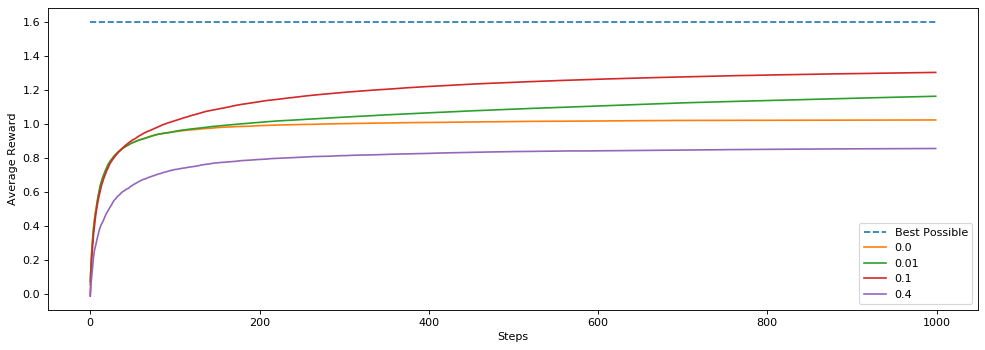

In [34]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.4])

plt.figure(figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')


for epsilon in epsilons:
    _, reward = run_experiment(num_experiments, num_steps, num_actions, epsilon)
    
    plt.plot(reward)
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

As can be seen by the graph, for this particular situation, an epsilon of 0.1 is the most optimal among the tested values. Smaller values do converge, but they explore so slowly that it takes a lot of time for the agent to find the optimal solution. On the other hand, really high values of epsilon cause the agent to not be able to explout its current knowledge of the environment. 

## Section 4: The Effect of Step Size

In Section 1 of this assignment, we decayed the step size over time based on action-selection counts. The step-size was 1/N(A), where N(A) is the number of times action A was selected. This is the same as computing a sample average. We could also set the step size to be a constant value, such as 0.1. What would be the effect of doing that? And is it better to use a constant or the sample average method?

To investigate this question, let’s start by creating a new agent that has a constant step size. This will be nearly identical to the agent created above. You will use the same code to select the epsilon-greedy action. You will change the update to have a constant step size instead of using the 1/N(A) update.

In [35]:
class AgentCustomStepsize(EpsilonGreedyAgent):
    # Here, we will implement an agent that inherits from the e-greedy
    # but also allows us to input a function as the step-size
    # Previous implementations used the sample average 1/N(A) to 
    # decay the learning process over time. Now we can test other
    # types of step-size.
    # The stepsize function receives an array of counts of num_experiments size
    # It must output a weight for updating the estimates
    def __init__(self, reward_estimates, epsilon, stepsize):
        EpsilonGreedyAgent.__init__(self, reward_estimates, epsilon)
        # Store the stepsize function
        self.stepsize = stepsize
        
    def update_estimates(self, reward, action):
        # We need to override the updating function so that it uses
        # the stepsize function
        n = self.action_count[np.arange(self.num_experiments), action]
        # get the weights for updating the value
        weights = self.stepsize(n)
        
        # Compute the difference between the received rewards vs the reward estimates
        error = reward - self.reward_estimates[np.arange(self.num_experiments), action]
        # Update the reward difference incementally
        self.reward_estimates[np.arange(self.num_experiments), action] += weights*error

Let's test this implementation with the already known stepsize function, the sample-average method, as well as some constant values with predictable behaviors.

In [36]:
def s_avg(n):
    # Return the inverse of the number of times each action was taken
    return 1/n

def zeros(n):
    return 0

def ones(n):
    return 1

In [37]:
# Testing the agent
# Sample Average / Greedy Agent
test_agent = AgentCustomStepsize(np.array([[1,-1,-1]]), 0, s_avg)

for i in range(2):
    # take an action
    action = test_agent.get_action()
    # Update the estimates with a known reward
    test_agent.update_estimates(np.array([i]), action)
    # First iteration should set action 0 with reward estimate 0
    # Second iteration should set action 0 with reward estimate 0.5

# Expected return in this case should be [[0.5,-1,-1]]
np.testing.assert_array_equal(test_agent.reward_estimates,np.array([[0.5,-1,-1]]))

# zero step-size / Greedy Agent
test_agent = AgentCustomStepsize(np.array([[1,-1,-1]]), 0, zeros)

for i in range(2):
    # take an action
    action = test_agent.get_action()
    # Update the estimates with a known reward
    test_agent.update_estimates(np.array([i]), action)
    # No matter what, a step-size of zero with not update the reward estimates

# Expected return in this case should be [[1,-1,-1]]
np.testing.assert_array_equal(test_agent.reward_estimates,np.array([[1,-1,-1]]))

# zero step-size / Greedy Agent
test_agent = AgentCustomStepsize(np.array([[1,-1,-1]]), 0, ones)

for i in range(3):
    # take an action
    action = test_agent.get_action()
    # Update the estimates with a known reward
    test_agent.update_estimates(np.array([i]), action)
    # First iteration should set action 0 with reward estimate 0
    # Second iteration should set action 0 with reward estimate 1
    # Third iteration should set action 0 with reward estimate 2

# Expected return in this case should be [[1,-1,-1]]
np.testing.assert_array_equal(test_agent.reward_estimates,np.array([[2,-1,-1]]))

In [38]:
def run_stepsize_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1, stepsize=s_avg):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = AgentCustomStepsize(np.zeros((num_experiments, num_actions)), epsilon, stepsize)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:03<00:00, 259.36it/s]


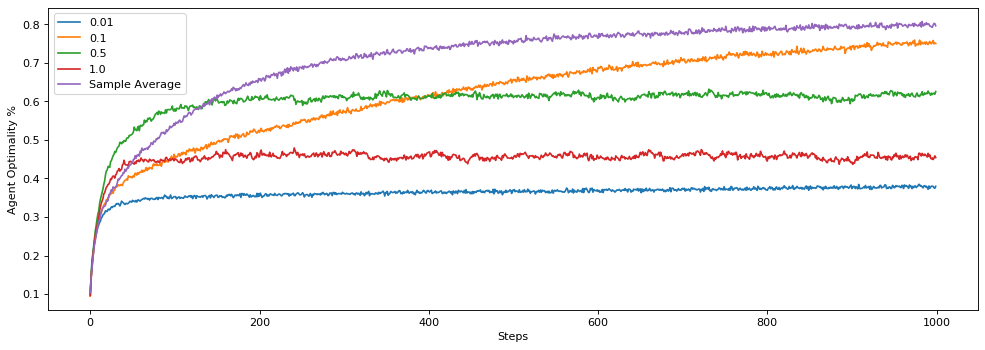

In [60]:
num_experiments = 5000
num_steps = 1000
num_actions = 10
epsilon = 0.1
stepsizes = [lambda n: 0.01, lambda n: 0.1, lambda n: 0.5, lambda n: 1.0, lambda n: 1/n]
stepsize_vals = [0.01, 0.1, 0.5, 1.0, 'Sample Average'] # Used for the plot legends only

# Let's add some dictionaries for storing estimated values over time. This is for later logging
q_values = {step_size: np.zeros((num_experiments, num_steps, num_actions)) for step_size in stepsizes}
true_values = {step_size: None for step_size in stepsizes}
best_actions = {step_size: np.zeros((num_experiments,num_steps)) for step_size in stepsizes}

plt.figure(figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

for stepsize in stepsizes:
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    true_values[stepsize] = np.copy(env.mean)
    # Initialize the agent
    agent = AgentCustomStepsize(np.zeros((num_experiments, num_actions)), epsilon, stepsize)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        q_values[stepsize][:,i] = agent.reward_estimates
        best_actions[stepsize][:,i] = action == optimal
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    
    plt.plot(optimality)

plt.legend(stepsize_vals)
plt.xlabel("Steps")
plt.ylabel("Agent Optimality %")
plt.show()

Notice first that we are now plotting the amount of time that the best action is taken rather than the average reward. To better understand the performance of an agent, it can be useful to measure specific behaviors, beyond just how much reward is accumulated. This measure indicates how close the agent’s behaviour is to optimal.

It seems as though 1/N(A) performed better than the others, in that it reaches a solution where it takes the best action most frequently. Now why might this be? Why did a step size of 0.5 start out better but end up performing worse? Why did a step size of 0.01 perform so poorly?

Let's dig into this further below. Let’s plot how well each agent tracks the true value, where each agent has a different step size method.

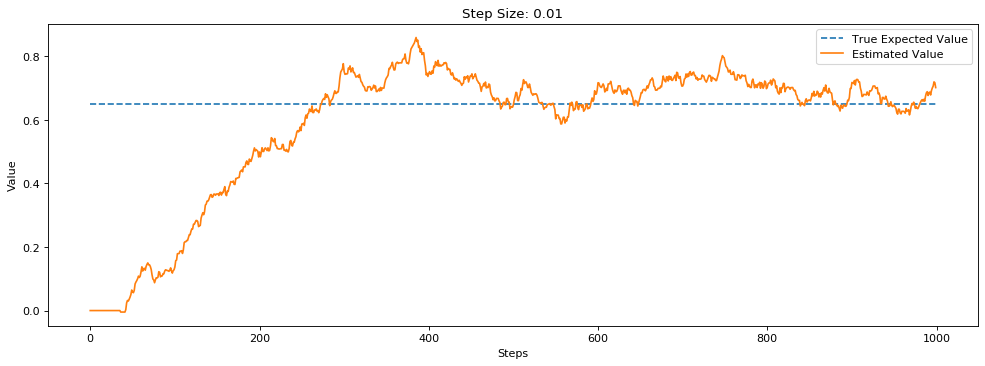

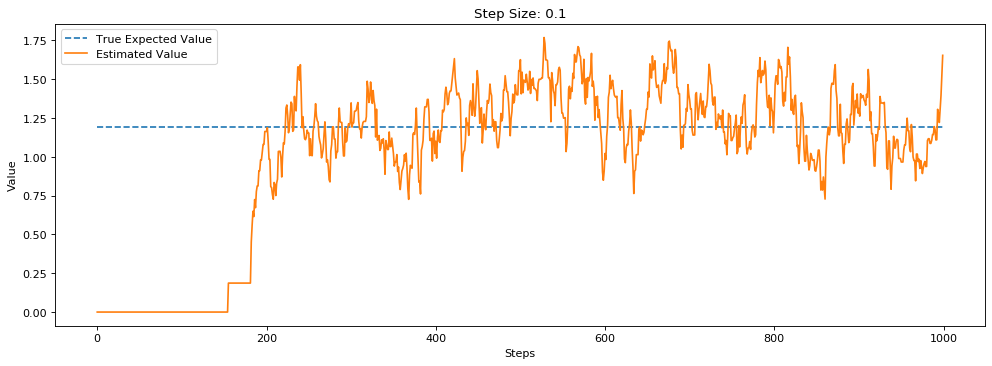

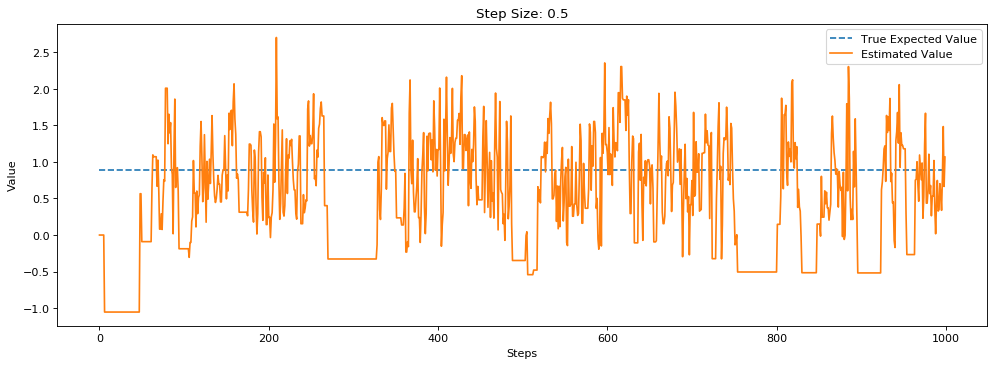

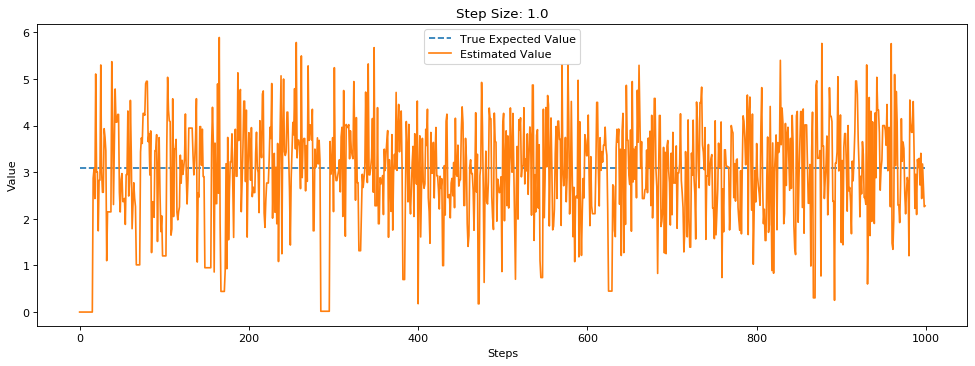

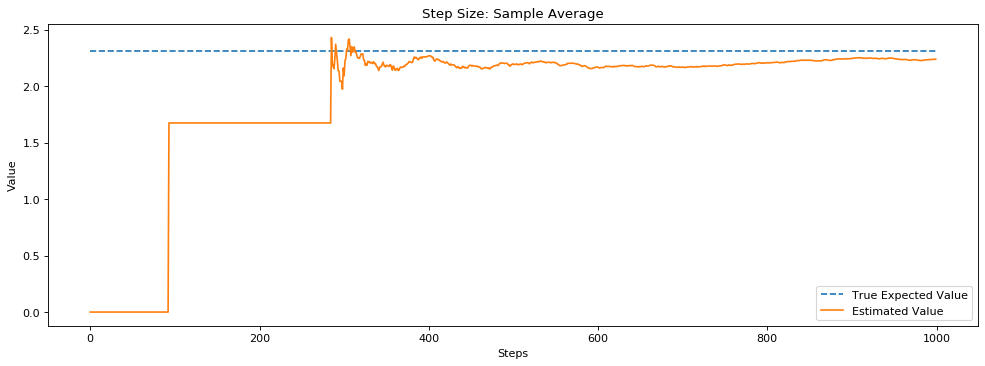

In [65]:
experiment = np.random.randint(num_experiments)
for i, step_size in enumerate(stepsizes):
    plt.figure(figsize=(15, 5), dpi= 80, facecolor='w', edgecolor='k')
    largest = np.argmax(true_values[step_size][experiment])
    plt.plot([true_values[step_size][experiment,largest] for _ in range(num_steps)], linestyle="--")
    plt.title("Step Size: {}".format(stepsize_vals[i]))
    plt.plot(q_values[step_size][experiment,:, largest])
    plt.legend(["True Expected Value", "Estimated Value"])
    plt.xlabel("Steps")
    plt.ylabel("Value")
    plt.show()
    

You may run the cell above multiple times to see different results. Here, the conclusions will be drawn from the general case. Some times you may see that the epsilon of 0.01 does reach the expected value. There's some randomness in the results, but remember that the graph comparing the different epsilon's performances show that this is not usually the case.

These plots help clarify the performance differences between the different step sizes. A step size of 0.01 makes such small updates that the agent’s value estimate of the best action does not get close to the actual value. Step sizes of 0.5 and 1.0 both get close to the true value quickly, but are very susceptible to stochasticity in the rewards. The updates overcorrect too much towards recent rewards, and so oscillate around the true value. This means that on many steps, the action that pulls the best arm may seem worse than it actually is. A step size of 0.1 updates fairly quickly to the true value, and does not oscillate as widely around the true values as 0.5 and 1.0. This is one of the reasons that 0.1 performs quite well. Finally we see why 1/N(A) performed well. Early on while the step size is still reasonably high it moves quickly to the true expected value, but as it gets pulled more its step size is reduced which makes it less susceptible to the stochasticity of the rewards.

Does this mean that 1/N(A) is always the best? When might it not be? One possible setting where it might not be as effective is in non-stationary problems. You learned about non-stationarity in the lessons. Non-stationarity means that the environment may change over time. This could manifest itself as continual change over time of the environment, or a sudden change in the environment.

Let's look at how a sudden change in the reward distributions affects a step size like 1/N(A). This time we will run the environment for 2000 steps, and after 1000 steps we will randomly change the expected value of all of the arms. We compare two agents, both using epsilon-greedy with epsilon = 0.1. One uses a constant step size of 0.1, the other a step size of 1/N(A) that reduces over time.

100%|██████████| 2000/2000 [00:07<00:00, 282.91it/s]


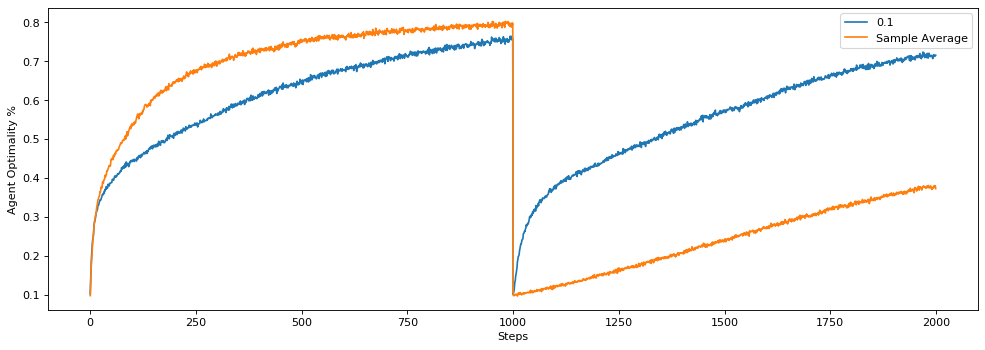

In [67]:
num_experiments = 5000
num_steps = 2000
num_actions = 10
epsilon = 0.1
stepsizes = [lambda n: 0.1, lambda n: 1/n]
stepsize_vals = [0.1, 'Sample Average'] # Used for the plot legends only

plt.figure(figsize=(15,5), dpi=80, facecolor='w', edgecolor='k')

for stepsize in stepsizes:
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = AgentCustomStepsize(np.zeros((num_experiments, num_actions)), epsilon, stepsize)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
        
        # Change the environment suddenly if we're at the middle of the number of steps
        if (i == 999):
           # Reinitialize the environment to cause non-stationarity
            env = ArmedBanditsGaussian(num_experiments, num_actions)
            #Store the optimal actions for later use
            optimal = np.argmax(env.mean, axis=1)
    
    plt.plot(optimality)

plt.legend(stepsize_vals)
plt.xlabel("Steps")
plt.ylabel("Agent Optimality %")
plt.show()